- dataset : https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification

## Install required packages

In [1]:
from google.colab import drive
drive.mount("/content/drive")
import os
import sys
sys.path.append("/drive/MyDrive/CS7650_NLP_Project")
path = "./drive/MyDrive/CS7650_NLP_Project/"

Mounted at /content/drive


In [2]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 28.2 MB/s 
     |████████████████████████████████| 287 kB 65.5 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import html
import nltk
import contractions # I'd -> I would
from nltk.corpus import stopwords

import datetime
import torch
import random
from sklearn.utils import shuffle

from collections import Counter
# from wordcloud import WordCloud, STOPWORD

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', None)

random_seed = 42
np.random.seed(random_seed)

nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Part 1. Import Data

In [5]:
train_org = pd.read_csv(path+"dataset/train.csv")
test_org = pd.read_csv(path+"dataset/test.csv")

In [6]:
train_org.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [7]:
train = train_org[[
    'comment_text',
    'target',
    # 'toxicity_annotator_count',
    'physical_disability',
    'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness',
    'other_disability'
    ]]

In [8]:
train[(train['physical_disability'] > 0) & (train['target'] > 0.5)].head(20)

,comment_text,target,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
12151,"I have never seen any elected Republican willing to ""Work together"" with members of the Democratic party to get things accomplished that they were elected to do, represent the people who voted them into office, not just the wealthy, big corporations, or corporations. A democrat mayor Berkowitz announces Anchorage will see a $14M surplus in 2015. Some of it could be attributed to no snow. Republicans are the only ones trying to eliminate the vote for women and minorities. There are people who can't see that Republicans are in office to further their own agenda, not the interests of the people who voted for them. Dumb and blind people are easily lead and manipulated.",0.600000,0.166667,0.000000,0.000000,0.000000
16346,"On the other hand, if you were a homosexual stoner with a pre-existing medical condition who works in the public sector - my guess is that Mr. Obama has been great.",1.000000,0.166667,0.000000,0.000000,0.000000
23795,Another sicko. When a man chooses to hit a woman he is no longer a man.,0.533333,0.001623,0.000541,0.037338,0.002165
25998,"OK, she's the wrong color and you don't like her hair. Anything else you wanna whine about? Watch out, friend--I might run for school board next time. If I win, then you'll have a (gasp!) MUSLIM on the school board. Try not to have a stroke.",0.600000,0.100000,0.000000,0.100000,0.000000
28978,They always run from the facts that expose their ridiculous nonsense for what it is. They debate like cowards. It is why I refer to their liberalism as a mental illness.,0.657143,0.100000,0.000000,0.500000,0.000000
31772,"If a dog is in its own yard and you shoot it, you need to be charged. Since when can you just start firing off guns? Mellerstig has mental problems. He needs some jail and then some therapy.",0.600000,0.100000,0.000000,0.800000,0.000000
37279,"If the state is going to have non-consensual sex with us, make it as painless as possible with a SIMPLE flat tax of XX % of income (even our mindless politicos can do that math), NO BREAKS, NO EXCEPTIONS EXCEPT VETERANS. 5% break for veterans, and NO tax for disabled VETERANS. NONE. \nDid YOU do your duty or do you not care?\nSo simple, but unlikely because politicians will not be able to worm their way out of paying.",0.800000,0.166667,0.000000,0.000000,0.000000
39895,"Donk, are you suffering from some variation of Asperger's? Your brains get beat out and you just keep on keepin' on....",0.600000,0.100000,0.200000,0.200000,0.000000
62870,"They also may have been particularly unlikely to share their views with a visibly disabled, ethnically-mysterious-this-must-be-some-kind-of-brown outsider.\n\nHis ties to Imago Dei sank his campaign, IMHO. I am not alone in that opinion, as I do talk with a lot of other ""Portland Progressives""...I'm more of a crotchety center-left sort. I'm not car-free or skinny or ""not in East Portland"" or ""educated"" enough to be a Real Progressive. And yet, in living rooms around town, those of hetero couples and gay ones, PoCs and white alike, the three big strikes against Bailey were his uncritical support of his creepy church, that he's done little for many of his platform elements like affordable housing on the County Commission, and, out here, his utter ignorance of East Portland. \n\nI know, and am friends with, Mormons, Southern Baptists, etc. I used to be a Good Mormon Girl. I know shifty hate-filled churches when I see one, and Imago Dei is just that.",1.000000,0.200000,0.000000,0.000000,0.000000
75046,"Euphemism, obfuscation, overstatement, cliché: \n""Addressing illegal immigration""-\n""until the issue of Muslim terrorists are addressed""-\n""equating Trump to Hitler""-\n""shameless grossly misrepresent,"" ""deluded tripe,"" ""fearmongering drivel,"" regurgitating lies,"" ""herded mindless sheep""",0.833333,0.100000,0.100000,0.100000,0.000000


### Add column : toxic_class - Target
  - Very Toxic (a very hateful, aggressive, or disrespectful comment that is very likely to make you leave a discussion or give up on sharing your perspective)
  - Toxic (a rude, disrespectful, or unreasonable comment that is somewhat likely to make you leave a discussion or give up on sharing your perspective)
  - Hard to Say
  - Not Toxic

In [ ]:
train['toxic_class'] = np.where(
    train['target'] >= 0.75, "1VeryToxic",
    np.where(train['target'] >= 0.5, "2Toxic",
             np.where(train['target'] >= 0.25, "3HardtoSay", "4NotToxic"))
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Add column : Disability binary

In [ ]:
train['disability_bin'] = np.where(
    (train['physical_disability'] > 0) | (train['intellectual_or_learning_disability'] > 0) | (train['psychiatric_or_mental_illness'] > 0) | (train['other_disability'] > 0), 'Yes', 'No'
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train.head()

,comment_text,target,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,toxic_class,disability_bin
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,NaN,NaN,NaN,NaN,4NotToxic,No
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,NaN,NaN,NaN,NaN,4NotToxic,No
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,NaN,NaN,NaN,NaN,4NotToxic,No
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,NaN,NaN,NaN,NaN,4NotToxic,No
4,haha you guys are a bunch of losers.,0.893617,0.0,0.25,0.0,0.0,1VeryToxic,Yes


### NULL -> 0

In [ ]:
train.isnull().sum()

comment_text                                 0
target                                       0
physical_disability                    1399744
intellectual_or_learning_disability    1399744
psychiatric_or_mental_illness          1399744
other_disability                       1399744
toxic_class                                  0
disability_bin                               0
dtype: int64

In [ ]:
train = train.fillna(0)
train.isnull().sum()

comment_text                           0
target                                 0
physical_disability                    0
intellectual_or_learning_disability    0
psychiatric_or_mental_illness          0
other_disability                       0
toxic_class                            0
disability_bin                         0
dtype: int64

### Add column : Disability Category
- physical_cat, il_cat, pm_cat, other_cat
- >=0.75 : 1, >=0.5 : 2, >= 0.25 : 3, else 4

In [ ]:
train['physical_cat'] = np.where(
    train['physical_disability'] >= 0.75, "1",
    np.where(train['physical_disability'] >= 0.5, "2",
             np.where(train['physical_disability'] >= 0.25, "3", "4"))
)

In [ ]:
train['il_cat'] = np.where(
    train['intellectual_or_learning_disability'] >= 0.75, "1",
    np.where(train['intellectual_or_learning_disability'] >= 0.5, "2",
             np.where(train['intellectual_or_learning_disability'] >= 0.25, "3", "4"))
)

In [ ]:
train['pm_cat'] = np.where(
    train['psychiatric_or_mental_illness'] >= 0.75, "1",
    np.where(train['psychiatric_or_mental_illness'] >= 0.5, "2",
             np.where(train['psychiatric_or_mental_illness'] >= 0.25, "3", "4"))
)

In [ ]:
train['other_cat'] = np.where(
    train['other_disability'] >= 0.75, "1",
    np.where(train['other_disability'] >= 0.5, "2",
             np.where(train['other_disability'] >= 0.25, "3", "4"))
)

In [ ]:
train.head()

,comment_text,target,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,toxic_class,disability_bin,physical_cat,il_cat,pm_cat,other_cat
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.0,0.00,0.0,0.0,4NotToxic,No,4,4,4,4
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.0,0.00,0.0,0.0,4NotToxic,No,4,4,4,4
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.0,0.00,0.0,0.0,4NotToxic,No,4,4,4,4
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.0,0.00,0.0,0.0,4NotToxic,No,4,4,4,4
4,haha you guys are a bunch of losers.,0.893617,0.0,0.25,0.0,0.0,1VeryToxic,Yes,4,3,4,4


## Part 2. EDA

In [ ]:
train.describe()

,target,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,3.043875e-04,2.442398e-04,2.712230e-03,2.739263e-04
std,1.970757e-01,8.312833e-03,7.608965e-03,4.255257e-02,6.700469e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e-01


### Count : Disability & Toxic

In [ ]:
print("tot : ", len(train))
print("")
print(train['disability_bin'].value_counts().sort_index())
print("")
print(train['disability_bin'].value_counts(normalize=True).sort_index().mul(100).round(2).astype(str)+"%")
print("")
print(train['toxic_class'].value_counts().sort_index())
print("")
print(train['toxic_class'].value_counts(normalize=True).sort_index().mul(100).round(2).astype(str)+"%")

tot :  1804874

No     1787991
Yes      16883
Name: disability_bin, dtype: int64

No     99.06%
Yes     0.94%
Name: disability_bin, dtype: object

1VeryToxic      38368
2Toxic         105966
3HardtoSay     124281
4NotToxic     1536259
Name: toxic_class, dtype: int64

1VeryToxic     2.13%
2Toxic         5.87%
3HardtoSay     6.89%
4NotToxic     85.12%
Name: toxic_class, dtype: object


In [ ]:
pd.crosstab(train['disability_bin'], train['toxic_class'])

toxic_class,1VeryToxic,2Toxic,3HardtoSay,4NotToxic
disability_bin,,,,
No,37417,103319,121906,1525349
Yes,951,2647,2375,10910


In [ ]:
pd.crosstab(train['disability_bin'], train['toxic_class'], normalize="all")

toxic_class,1VeryToxic,2Toxic,3HardtoSay,4NotToxic
disability_bin,,,,
No,0.020731,0.057244,0.067543,0.845128
Yes,0.000527,0.001467,0.001316,0.006045


In [ ]:
pd.crosstab(train['disability_bin'], train['toxic_class'], normalize="index") # rows

toxic_class,1VeryToxic,2Toxic,3HardtoSay,4NotToxic
disability_bin,,,,
No,0.020927,0.057785,0.068180,0.853108
Yes,0.056329,0.156785,0.140674,0.646212


In [ ]:
sns.set(style='whitegrid')

Text(0.5, 1.0, 'Disability - Toxicity')

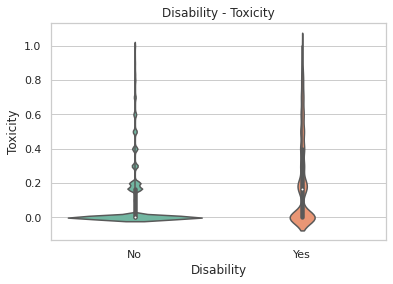

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.violinplot(data=train, x='disability_bin', y='target', palette="Set2")
ax.set_xlabel("Disability")
ax.set_ylabel("Toxicity")
ax.set_title("Disability - Toxicity")

Text(0, 0.5, 'other')

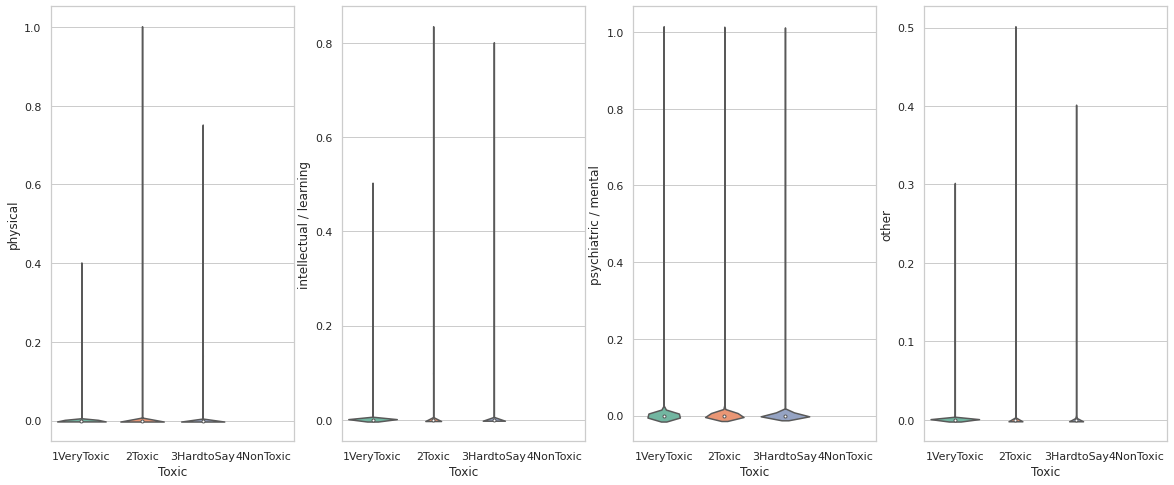

In [ ]:
f, axes = plt.subplots(1,4)
f.set_figheight(8)
f.set_figwidth(20)

ax1 = sns.violinplot(
    data=train,
    x='toxic_class',
    y='physical_disability',
    palette="Set2",
    order=['1VeryToxic', '2Toxic', '3HardtoSay', '4NonToxic'],
    ax=axes[0])
ax1.set_xlabel("Toxic")
ax1.set_ylabel("physical")

ax2 = sns.violinplot(
    data=train,
    x='toxic_class',
    y='intellectual_or_learning_disability',
    palette="Set2",
    order=['1VeryToxic', '2Toxic', '3HardtoSay', '4NonToxic'],
    ax=axes[1])
ax2.set_xlabel("Toxic")
ax2.set_ylabel("intellectual / learning")

ax3 = sns.violinplot(
    data=train,
    x='toxic_class',
    y='psychiatric_or_mental_illness',
    palette="Set2",
    order=['1VeryToxic', '2Toxic', '3HardtoSay', '4NonToxic'],
    ax=axes[2])
ax3.set_xlabel("Toxic")
ax3.set_ylabel("psychiatric / mental")

ax4 = sns.violinplot(
    data=train,
    x='toxic_class',
    y='other_disability',
    palette="Set2",
    order=['1VeryToxic', '2Toxic', '3HardtoSay', '4NonToxic'],
    ax=axes[3])
ax4.set_xlabel("Toxic")
ax4.set_ylabel("other")

### Disabilities

In [ ]:
pd.crosstab(train['physical_cat'], train['il_cat'])

il_cat,1,2,3,4
physical_cat,,,,
1,0,0,1,10
2,0,2,3,66
3,2,3,4,365
4,12,74,221,1804111


In [ ]:
pd.crosstab(train['physical_cat'], train['pm_cat'])

pm_cat,1,2,3,4
physical_cat,,,,
1,7,3,0,1
2,17,9,5,40
3,37,30,19,288
4,2552,2234,1563,1798069


In [ ]:
pd.crosstab(train['physical_cat'], train['other_cat'])

other_cat,2,3,4
physical_cat,,,
1,0,0,11
2,0,2,69
3,0,10,364
4,5,164,1804249


In [ ]:
pd.crosstab(train['il_cat'], train['pm_cat'])

pm_cat,1,2,3,4
il_cat,,,,
1,1,0,0,13
2,4,3,18,54
3,17,9,48,155
4,2591,2264,1521,1798176


In [ ]:
pd.crosstab(train['il_cat'], train['other_cat'])

other_cat,2,3,4
il_cat,,,
1,0,2,12
2,0,0,79
3,0,3,226
4,5,171,1804376


In [ ]:
pd.crosstab(train['pm_cat'], train['other_cat'])

other_cat,2,3,4
pm_cat,,,
1,1,10,2602
2,0,0,2276
3,0,5,1582
4,4,161,1798233


### Sentence Example

In [ ]:
print('no disability & not toxic : ')
print(train[(train['disability_bin'] == "No") & (train['toxic_class'] == "4NotToxic")].iloc[3,0])
print("")
print('no disability & toxic : ')
print(train[(train['disability_bin'] == "No") & (train['toxic_class'] == "1VeryToxic")].iloc[1,0])
print("")
print('disability & not toxic : ')
print(train[(train['disability_bin'] == "Yes") & (train['toxic_class'] == "4NotToxic")].iloc[7,0])
print("")
print('disability & hard to say : ')
print(train[(train['disability_bin'] == "Yes") & (train['toxic_class'] == "3HardtoSay")].iloc[35,0])
print("")
print('disability & toxic : ')
print(train[(train['disability_bin'] == "Yes") & (train['toxic_class'] == "2Toxic")].iloc[16,0])
print("")
print('disability & very toxic : ')
print(train[(train['disability_bin'] == "Yes") & (train['toxic_class'] == "1VeryToxic")].iloc[30,0])

no disability & not toxic : 
Is this something I'll be able to install on my site? When will you be releasing it?

no disability & toxic : 
This bitch is nuts. Who would read a book by a woman.

disability & not toxic : 
Assuming this was a blind tasting?

disability & hard to say : 
Why did you not turn him in to the authorities?  He is not allowed to possess a weapon or have a CHL if he suffers from mental illness.  If you knew this and did not report him you are culpable.  Much like Brian Babb, whose family and friends did not remove his weapons.  If all people fail follow the gun laws then how can they blame the guns for all the gun violence?

disability & toxic : 
You are a gross individual. You're probably friends or family of this mental man. That cat did not deserve to die.

disability & very toxic : 
You do not need to be a drunk to be a moron.


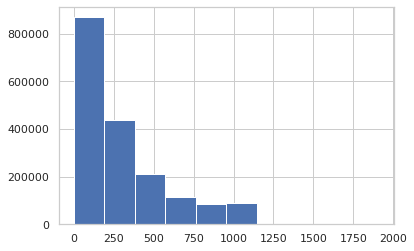

In [ ]:
train['length'] = train['comment_text'].apply(lambda x: len(str(x)))
train['length'].hist()
plt.show()

## Part 3. Cleansing
- remove unnecessary words, emoji...
- sampling
- tokenize
- save : v1.csv

In [ ]:
def fix_html(x: str) -> str:
    re1 = re.compile(r"  +")
    x = (
        x.replace("#39;", "'")
        .replace("amp;", "&")
        .replace("#146;", "'")
        .replace("nbsp;", " ")
        .replace("#36;", "$")
        .replace("\\n", "\n")
        .replace("quot;", "'")
        .replace("<br />", "\n")
        .replace('\\"', '"')
        .replace(" @.@ ", ".")
        .replace(" @-@ ", "-")
        .replace(" @,@ ", ",")
        .replace("\\", " \\ ")
    )
    return re1.sub(" ", html.unescape(x))

def no_emoji(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text) # no emoji    

# len(w) == 1 -> remove
def rm_one(text):
    rst = ""
    for w in text:
        if len(w) > 1:
            rst += w + " "
    return rst

def clean_text(text):
    text = fix_html(text)
    text = no_emoji(text)
    text = text.lower()
    text = contractions.fix(text) # I'd -> I would
    text = re.sub(r'"', '', text)
    text = re.sub(r":", "", text)
    text = re.sub(r"\n", "", text)
    # text = re.sub(r'(!)1+', '', text) # !!! -> NA
    # text = re.sub(r'(?)1+', '', text) # ?? -> NA
    text = re.sub(r"([/#\n])", r" \1 ", text) # Add spaces around / and # in `t`. \n
    text = re.sub(" {2,}", " ", text) # Remove multiple spaces in `t`.
    text = re.sub(r"(\n(\s)*){2,}", "\n", text) # multi new lines -> 1 new line
    text = text.strip() # remove any leading/trailing characters (default : space)
    return text

# def only_eng(text):
#     # filter non-english words
#     words = set(nltk.corpus.words.words())
#     rst = ""
#     for w in text:
#         if w in words:
#             rst += w
#     return rst

In [ ]:
train['tokenized'] = train['comment_text'].apply(lambda x: clean_text(x))

## Part 4. Tokenize

### Data Split for Tokenizing
- Prevent ram error

In [ ]:
a = int(len(train)/10)
train_1 = train[   :a*1]
train_2 = train[a*1:a*2]
train_3 = train[a*2:a*3]
train_4 = train[a*3:a*4]
train_5 = train[a*4:a*5]
train_6 = train[a*5:a*6]
train_7 = train[a*6:a*7]
train_8 = train[a*7:a*8]
train_9 = train[a*8:a*9]
train_10 = train[a*9:]

### Tokenize

In [ ]:
print('train_1')
train_1['tokenized'] = train_1['tokenized'].apply(lambda x: nltk.word_tokenize(x))
print('train_2')
train_2['tokenized'] = train_2['tokenized'].apply(lambda x: nltk.word_tokenize(x))
print('train_3')
train_3['tokenized'] = train_3['tokenized'].apply(lambda x: nltk.word_tokenize(x))
print('train_4')
train_4['tokenized'] = train_4['tokenized'].apply(lambda x: nltk.word_tokenize(x))
print('train_5')
train_5['tokenized'] = train_5['tokenized'].apply(lambda x: nltk.word_tokenize(x))
print('train_6')
train_6['tokenized'] = train_6['tokenized'].apply(lambda x: nltk.word_tokenize(x))
print('train_7')
train_7['tokenized'] = train_7['tokenized'].apply(lambda x: nltk.word_tokenize(x))
print('train_8')
train_8['tokenized'] = train_8['tokenized'].apply(lambda x: nltk.word_tokenize(x))
print('train_9')
train_9['tokenized'] = train_9['tokenized'].apply(lambda x: nltk.word_tokenize(x))
print('train_10')
train_10['tokenized'] = train_10['tokenized'].apply(lambda x: nltk.word_tokenize(x))

train_1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


train_2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


train_3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


train_4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


train_5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


train_6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


train_7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


train_8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


train_9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


train_10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train = pd.concat([train_1, train_2, train_3, train_4, train_5, train_6, train_7, train_8, train_9, train_10])

In [ ]:
train = shuffle(train)

In [ ]:
train.to_pickle("train.pkl")

### Sampling
- normal : disable = 1 : 1
- same percentage
  - normal very toxic : toxic : hard to say : not toxic = disability very toxic : toxic : hard to say : not toxic

In [ ]:
# train = shuffle(train)

In [ ]:
# normal_1 = train[(train['disability_bin'] == "No") & (train['toxic_class'] == "1VeryToxic")]
# normal_2 = train[(train['disability_bin'] == "No") & (train['toxic_class'] == "2Toxic")]
# normal_3 = train[(train['disability_bin'] == "No") & (train['toxic_class'] == "3HardtoSay")]
# normal_4 = train[(train['disability_bin'] == "No") & (train['toxic_class'] == "4NotToxic")]
# disable_1 = train[(train['disability_bin'] == "Yes") & (train['toxic_class'] == "1VeryToxic")]
# disable_2 = train[(train['disability_bin'] == "Yes") & (train['toxic_class'] == "2Toxic")]
# disable_3 = train[(train['disability_bin'] == "Yes") & (train['toxic_class'] == "3HardtoSay")]
# disable_4 = train[(train['disability_bin'] == "Yes") & (train['toxic_class'] == "4NotToxic")]

# print(len(normal_1), len(normal_2), len(normal_3), len(normal_4))
# print(len(disable_1), len(disable_2), len(disable_3), len(disable_4))

In [ ]:
# normal_1 = normal_1.sample(len(disable_1))
# normal_2 = normal_2.sample(len(disable_2))
# normal_3 = normal_3.sample(len(disable_3))
# normal_4 = normal_4.sample(len(disable_4))

# print(len(normal_1), len(normal_2), len(normal_3), len(normal_4))
# print(len(disable_1), len(disable_2), len(disable_3), len(disable_4))

In [ ]:
# normal = pd.concat([normal_1, normal_2, normal_3, normal_4])
# disable = pd.concat([disable_1, disable_2, disable_3, disable_4])
# df = pd.concat([normal, disable])
# print(len(normal), len(disable))

## Part 5. Train Val Test

- no disability : 1,787,911
- disability : 16,883
  - very toxic : 951
  - toxic : 2,647
  - hard to say 2,375
  - not toxic : 10,910
- train : val : test = 8 : 1 : 1

### import

In [ ]:
df = train

In [ ]:
df.head(1)

In [ ]:
pd.crosstab(df['disability_bin'], df['toxic_class'])

In [ ]:
# pd.crosstab(df['disability_bin'], df['toxic_class'], normalize='index')

In [ ]:
PADDING_VALUE = 0
UNK_VALUE     = 1

def split_train_val_test(df, props=[.8, .1, .1]):
    assert round(sum(props), 2) == 1 and len(props) >= 2
    train_df = df.iloc[:int(len(df)*props[0])                                ,:]
    val_df   = df.iloc[int(len(df)*props[0]):int(len(df)*(props[0]+props[1])),:]
    test_df  = df.iloc[int(len(df)*(props[0]+props[1])):                     ,:]    
    return train_df, val_df, test_df

In [ ]:
def generate_vocab_map(df, cutoff=2):
    vocab          = {"": PADDING_VALUE, "UNK": UNK_VALUE}
    reversed_vocab = None
    wordCnt = dict()

    for word in df["tokenized"]:
        wordCount = Counter(word)
        for (id, cnt) in wordCount.items():
            if id in wordCnt:
                wordCnt[id] += cnt
            else:
                wordCnt[id] = cnt
    
    value = 2
    for (id, cnt) in wordCnt.items():
        if cnt >= cutoff:
            vocab[id] = value
            value += 1
    
    reversed_vocab = {v: k for k, v in vocab.items()}
    
    return vocab, reversed_vocab

In [ ]:
# df_n = df[df['disability_bin'] == "No"]
# df_y = df[df['disability_bin'] == "Yes"]

### dataset with disability

In [ ]:
df                          = train.sample(frac=1)
# df                          = df[['tokenized','target', 'toxic_class']]
train_df, val_df, test_df   = split_train_val_test(df, props=[.8, .1, .1])
train_vocab, reverse_vocab  = generate_vocab_map(train_df)

In [ ]:
df.head(3)

In [ ]:
(len(train_df) / len(df)), (len(val_df) / len(df)), (len(test_df) / len(df))

In [ ]:
# df.to_csv('dataset_v2.csv')

In [ ]:
class HeadlineDataset(Dataset):
    
    def __init__(self, vocab, df, max_length=50):
        self.vocab = vocab
        self.df = df
        self.max_length = max_length
        return 
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        word_list = list()

        for i, word in enumerate(self.df.iloc[index].loc['tokenized']):
            if i == self.max_length:
                break
            if word not in train_vocab:
                value = train_vocab['UNK']
            else:
                value = train_vocab[word]
            word_list.append(value)       

        tokenized_word_tensor = torch.LongTensor(word_list)     
        curr_label = self.df.iloc[index].loc['toxic_class'] # label 0/1
        return tokenized_word_tensor, curr_label

In [ ]:
train_dataset = HeadlineDataset(train_vocab, train_df)
val_dataset   = HeadlineDataset(train_vocab, val_df)
test_dataset  = HeadlineDataset(train_vocab, test_df)
 
train_sampler = RandomSampler(train_dataset)
val_sampler   = RandomSampler(val_dataset)
test_sampler  = RandomSampler(test_dataset)

In [ ]:
i = 0
for x, y in train_dataset:
    print(x, y)
    i += 1
    if i > 10:
        break

In [ ]:
def collate_fn(batch, padding_value=PADDING_VALUE):

    texts, labels = [], []
    for src, tgt in batch:
        texts.append(src)
        labels.append(int(tgt[0]))

    padded_tokens = pad_sequence(texts, batch_first=True, padding_value=padding_value)
    padded_tokens = torch.LongTensor(padded_tokens)
    y_labels = torch.FloatTensor(labels)

    return padded_tokens, y_labels

In [ ]:
BATCH_SIZE = 16

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)
test_iterator  = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn)

In [ ]:
for x, y in test_iterator:
    print(x, y)
    print(f'x: {x.shape}')
    print(f'y: {y.shape}')
    break
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn)